In [1]:
%pip install --upgrade tensorflow keras scikit-learn opencv-python matplotlib keras_tuner keras_cv numpy seaborn

  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2.17.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


I0000 00:00:1727598408.031814   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727598408.036171   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727598408.097650   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727598408.097966   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [5]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [6]:
import tensorflow as tf
import keras
import pandas as pd
import os
import keras_cv
import matplotlib.pyplot as plt

/home/rob/.notebook/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
csv_file = 'ham10000_data/HAM10000_metadata.csv'
img_dir = 'ham10000_data/images'
file_ext = '.jpg'

df = pd.read_csv(csv_file)

image_paths = [
    os.path.join(img_dir, image_id + file_ext)
    for image_id in df['image_id']
]

print(f"Number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")

classes = sorted(df['dx'].unique())
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = df['dx'].map(lambda x: classes.index(x)).values
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Class to Index Mapping: {class_to_idx}")
print(f"Labels: {labels}")

Number of images: 10015
First 5 image paths: ['ham10000_data/images/ISIC_0027419.jpg', 'ham10000_data/images/ISIC_0025030.jpg', 'ham10000_data/images/ISIC_0026769.jpg', 'ham10000_data/images/ISIC_0025661.jpg', 'ham10000_data/images/ISIC_0031633.jpg']
Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class to Index Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Labels: [2 2 2 ... 0 0 4]


In [8]:
from IPython.display import display

display(df.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

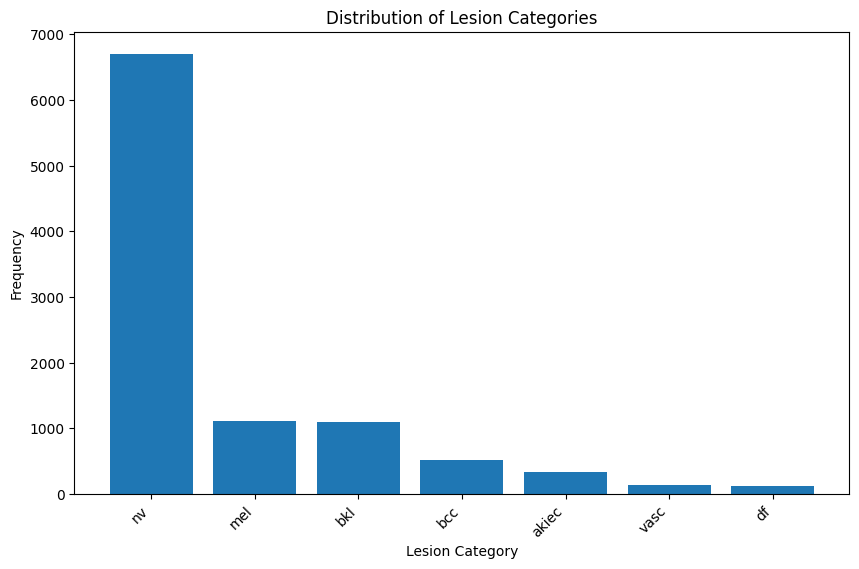

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
value_counts = df['dx'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title('Distribution of Lesion Categories')
plt.xlabel('Lesion Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
# import matplotlib.pyplot as plt
# import random
# import tensorflow as tf

# n_samples_per_class = 5

# plt.figure(figsize=(15, len(classes) * 3))

# for class_index, class_name in enumerate(classes):
#     class_indices = [i for i, label in enumerate(labels) if label == class_index]

#     random_class_indices = random.sample(class_indices, min(n_samples_per_class, len(class_indices)))

#     for i, idx in enumerate(random_class_indices):
#         img_path = image_paths[idx]
#         label = labels[idx]

#         img = tf.io.read_file(img_path)
#         img = tf.image.decode_jpeg(img, channels=3)

#         # Display image
#         plt.subplot(len(classes), n_samples_per_class, class_index * n_samples_per_class + i + 1)
#         plt.imshow(img)
#         plt.title(f"Class: {class_name}")
#         plt.axis('off')

# plt.tight_layout()
# plt.show()


In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

train_paths = []
train_labels = []
val_paths = []
val_labels = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_paths = [image_paths[i] for i in train_index]
    train_labels = labels[train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = labels[val_index]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

Training set size: 8012
Validation set size: 2003


I0000 00:00:1727598410.509686   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727598410.509998   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727598410.510203   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727598410.510387   45235 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [13]:
import tensorflow as tf

def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to (224, 224, 3)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Batch size
batch_size = 32

# Training dataset pipeline
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)  # Shuffle dataset for randomness
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)  # Batch the dataset
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch to optimize GPU usage
train_dataset = train_dataset.cache()  # Cache the dataset in memory for faster epochs

# Validation dataset pipeline
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)  # Batch validation dataset
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch to optimize GPU usage
val_dataset = val_dataset.cache()  # Cache validation dataset


In [14]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [15]:
for image, label in train_dataset.take(1):
    print(f"Image shape: {image.shape}, Label: {label}")

Image shape: (32, 224, 224, 3), Label: [5 5 1 4 4 5 5 5 5 5 1 5 5 2 0 5 5 5 5 5 5 5 2 5 5 2 5 5 1 4 5 5]


In [16]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))


In [17]:
import numpy as np

class_counts = np.bincount(train_labels)
total_counts = np.sum(class_counts)
class_prior = class_counts / total_counts
output_bias = np.log(class_prior)


def build_model(hp):

    strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():
        base_model = keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            pooling=None
        )

        base_model.trainable = False

        # base_model.trainable = hp.Choice('fine_tune_base_model', values=[False, True])
        # if base_model.trainable:
        #     fine_tune_at = hp.Int('fine_tune_at', min_value=100, max_value=150)
        #     for layer in base_model.layers[:fine_tune_at]:
        #         layer.trainable = False

        inputs = keras.Input(shape=(224, 224, 3))
        # x = data_augmentation(inputs)
        x = base_model(inputs, training=False)
        x = keras.layers.GlobalAveragePooling2D()(x)

        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.7, step=0.1)
        if dropout_rate > 0.0:
            x = keras.layers.Dropout(dropout_rate)(x)

        # Output Layer
        outputs = keras.layers.Dense(
            num_classes,
            activation='softmax',
            bias_initializer=keras.initializers.Constant(output_bias),
            kernel_regularizer = keras.regularizers.l2(hp.Float('l2_regularization', min_value=0.0, max_value=0.1, step=0.01))
        )(x)

        model = keras.Model(inputs, outputs)

        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

        optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
        if optimizer == 'adam':
            optimizer_instance = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            optimizer_instance = keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            optimizer_instance = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=[
                'accuracy'
            ]
        )

        return model


In [18]:
from keras_tuner import HyperModel

class ResNet50ClassWeights(HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            **kwargs,
            # class_weight=class_weight_dict  # Pass class weights here
        )


In [19]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    ResNet50ClassWeights(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search/resnet50/class_weights',
    project_name='hyperparameter_tuning'
)

tuner.search_space_summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Search space summary
Default search space size: 4
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.1, 'sampling': 'linear'}
l2_regularization (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.01, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}


In [20]:
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Trial 21 Complete [00h 02m 41s]
val_accuracy: 0.6683467626571655

Best val_accuracy So Far: 0.6683467626571655
Total elapsed time: 00h 55m 46s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
0.3               |0.5               |dropout_rate
0.04              |0                 |l2_regularization
0.0001            |0.0001            |learning_rate
rmsprop           |adam              |optimizer

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 2 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.6596 - loss: 1.3346 - val_accuracy: 0.6683 - val_loss: 1.1409
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6708 - loss: 1.1614 - val_accuracy: 0.6683 - val_loss: 1.1340

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6708 - loss: 1.1509 - val_accuracy: 0.6683 - val_loss: 1.1326
Epoch 9/10
175/250 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6723 - loss: 1.1490

: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameters:
Best Learning Rate: {best_hps.get('learning_rate')}
Best Weight Decay: {best_hps.get('weight_decay')}
""")



In [ ]:
from keras.callbacks import ModelCheckpoint

best_model = tuner.hypermodel.build(best_hps)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        filepath='models/resnet50-ham10000.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
]

history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks
)

best_model.save('models/resnet50-ham10000-final.keras')

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []

def get_predictions(dataset):
    for images, labels in dataset:
        predictions = best_model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for validation dataset
y_true, y_pred = get_predictions(val_dataset)

In [ ]:
# Classification Report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Per-class Accuracy Plot
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_accuracies)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Class distribution in training set
train_labels = np.concatenate([labels.numpy() for _, labels in train_dataset])
train_class_dist = np.bincount(train_labels) / len(train_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=train_class_dist)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()